# Homework 2 (Loans)

Description from Kaggle competation:  
The goal is to decide whether or not to approve a loan to a new client based on the predictors that are provided. If you predict a 1, that means that you are predicting that the customer will pay back the laon. The data columns are described in the MetaData.csv file. The response for training is the MIS_Status column, where PIF = paid in full = a successful loan.

You'll evaluate using the mean F1 score (see the Kaggle overview page for more information). Mean F1 scores closer to 1 are better scores. On the leaderboard I've included a benchmark which I created by randomly predicting 0 or 1 for the test data set (see random.guess on the leaderboard).

In [2]:
# import analysis packages
import keras
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout
from keras import models
from keras.regularizers import l2
from keras.utils import to_categorical
import keras.backend as back
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

### Data Cleaning

In [3]:
# read data from .csvs
trainDF = pd.read_csv('./loan_train.csv')
testDF = pd.read_csv('./loan_test.csv')

# separate response/prediction columns
trainResp = np.where(trainDF['MIS_Status'] == 'P I F', 1, 0)
trainDF.drop('MIS_Status', axis = 1, inplace = True)
testIDs = testDF['CustomerId']
testDF.drop('CustomerId', axis = 1, inplace = True)

# combine data sets for preprocessing
trainDF['source'] = 'train'
testDF['source'] = 'test'
fullDF = pd.concat([trainDF, testDF], axis = 0)

# check data frame dimensions
display(trainDF.shape)
display(testDF.shape)
display(fullDF.shape)

# factor categorical predictors
fullDF['NAICS'] = fullDF['NAICS'].apply(lambda x: str(x))
fullDF['NewExist'] = fullDF['NewExist'].apply(lambda x: str(x))
fullDF['UrbanRural'] = fullDF['UrbanRural'].apply(lambda x: str(x))
fullDF['RevLineCr'] = np.where(fullDF['RevLineCr'] == 'Y', 'Y', 'N')
fullDF['LowDoc'] = np.where(fullDF['LowDoc'] == 'Y', 'Y', 'N')
fullDF['New'] = fullDF['New'].apply(lambda x: str(x))
fullDF['RealEstate'] = fullDF['RealEstate'].apply(lambda x: str(x))
fullDF['Recession'] = fullDF['Recession'].apply(lambda x: str(x))

# selected predictors
predictors = ['NAICS', 'Term', 'NoEmp', 'CreateJob', 'RetainedJob', 'UrbanRural', 'DisbursementGross', 'GrAppv', 'New', 'Portion', 'Recession']
src = fullDF['source']
fullDF = fullDF[predictors]

# check data types
display(fullDF.info())

# peek at data
display(fullDF.head())

(1102, 31)

(1000, 31)

(2102, 31)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2102 entries, 0 to 999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NAICS              2102 non-null   object 
 1   Term               2102 non-null   int64  
 2   NoEmp              2102 non-null   int64  
 3   CreateJob          2102 non-null   int64  
 4   RetainedJob        2102 non-null   int64  
 5   UrbanRural         2102 non-null   object 
 6   DisbursementGross  2102 non-null   int64  
 7   GrAppv             2102 non-null   int64  
 8   New                2102 non-null   object 
 9   Portion            2102 non-null   float64
 10  Recession          2102 non-null   object 
dtypes: float64(1), int64(6), object(4)
memory usage: 197.1+ KB


None

,NAICS,Term,NoEmp,CreateJob,RetainedJob,UrbanRural,DisbursementGross,GrAppv,New,Portion,Recession
0,531210,84,2,0,0,2,11000,11000,0,0.50000,0
1,531312,300,7,0,7,1,866800,866800,0,0.75000,0
2,532230,84,3,0,3,1,77377,85000,0,0.50000,0
3,531312,300,10,0,0,1,800100,810000,0,0.75000,0
4,531210,300,2,0,2,1,1054200,1056200,0,0.72611,0


In [4]:
# scale numeric predictors and encode categorical predictors
findNumPredictors = make_column_selector(dtype_exclude = object)
findCatPredictors = make_column_selector(dtype_include = object)
transform = make_column_transformer((MinMaxScaler(), findNumPredictors),
                                    (OneHotEncoder(), findCatPredictors))

# get new column names
colNames = transform.fit(fullDF).get_feature_names_out()

# transform data
modelDF = pd.DataFrame.sparse.from_spmatrix(transform.fit_transform(fullDF), columns = colNames)

In [5]:
# split data into training, validation, and test sets
modelTrain = modelDF.loc[np.where(src == 'train')]
modelTest = modelDF.iloc[np.where(src == 'test')]
X_train, X_valid, y_train, y_valid = train_test_split(modelTrain, trainResp, test_size = 0.2, random_state = 4192023)

# check data frame dimensions
display(X_train.shape)
display(y_train.shape)
display(X_valid.shape)
display(y_valid.shape)
display(modelTest.shape) 

(881, 38)

(881,)

(221, 38)

(221,)

(1000, 38)

### Modeling

In [132]:
# set random seed
np.random.seed(4192023)

# tune KNN model
Kvalues = range(1, 50)
knnFit = KNeighborsClassifier()
knnTune = GridSearchCV(knnFit, param_grid = {'n_neighbors': Kvalues}, cv = 5, n_jobs = -1, verbose = 1)
knnTune.fit(X_train, y_train)
K = knnTune.best_params_['n_neighbors']

# fit KNN model
knnFit = KNeighborsClassifier(n_neighbors = K)
cvResults = cross_val_score(knnFit, X_train, y_train, cv = 10, n_jobs = -1, verbose = 0)

# cross-validation accuracy
print(f"Neighbors considered: {K}")
print(f"Cross-validation accuracy: {(np.mean(cvResults) * 100).round(2)}%")

Fitting 5 folds for each of 49 candidates, totalling 245 fits
Neighbors considered: 13
Cross-validation accuracy: 76.16%


In [133]:
# tune random forest classifier
Mvalues = range(1, len(X_train.columns))
rfFit = RandomForestClassifier(random_state = 4192023)
rfTune = GridSearchCV(rfFit, param_grid = {'max_features': Mvalues}, cv = 5, n_jobs = -1, verbose = 1)
rfTune.fit(X_train, y_train)
M = rfTune.best_params_['max_features']

# fit random forest model
rfFit = RandomForestClassifier(max_features = M, n_estimators = 1000, random_state = 4192023)
cvResults = cross_val_score(rfFit, X_train, y_train, cv = 10, n_jobs = -1, verbose = 0)

# cross-validation accuracy
print(f"Features considered: {M}")
print(f"Cross-validation accuracy: {(np.mean(cvResults) * 100).round(2)}%")

Fitting 5 folds for each of 37 candidates, totalling 185 fits
Features considered: 9
Cross-validation accuracy: 80.02%


In [134]:
# tune gradient boosted classifier
Lvalues = [.001, .01, .1, 1, 10, 100]
Dvalues = range(1, 8)
gbFit = GradientBoostingClassifier(n_estimators = 1000, random_state = 4192023)
gbTune = GridSearchCV(gbFit, param_grid = {'learning_rate': Lvalues, 'max_depth': Dvalues}, cv = 5, n_jobs = -1, verbose = 1)
gbTune.fit(X_train, y_train)
L = gbTune.best_params_['learning_rate']
D = gbTune.best_params_['max_depth']

# fit gradient boosted model
gbFit = GradientBoostingClassifier(learning_rate = L, max_depth = D, n_estimators = 1000, random_state = 4192023)
cvResults = cross_val_score(gbFit, X_train, y_train, cv = 10, n_jobs = -1, verbose = 0)

# cross-validation accuracy
print(f"Learning rate: {L}")
print(f"Maximum depth: {D}")
print(f"Cross-validation accuracy: {(np.mean(cvResults) * 100).round(2)}%")

Fitting 5 folds for each of 42 candidates, totalling 210 fits
Learning rate: 0.1
Maximum depth: 1
Cross-validation accuracy: 81.95%


In [10]:
# F1 score function
def F1Score(y_true, y_pred):
    # confusion metrics
    tp = back.sum(back.round(back.clip(y_true * y_pred, 0, 1)))
    possp = back.sum(back.round(back.clip(y_true, 0, 1)))
    predp = back.sum(back.round(back.clip(y_pred, 0, 1)))

    # compute precision and recall
    precision = tp / (predp + back.epsilon())
    recall = tp / (possp + back.epsilon())

    # compute F1 score
    f1 = 2 * (precision * recall) / (precision + recall + back.epsilon())
    return f1

# model fitting and evaluation function
def EvaluateModel(model):
    # set random seed
    np.random.seed(462023)
    tf.random.set_seed(482023)

    # compile model
    model.compile(optimizer = 'rmsprop',
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy', F1Score])

    # model summary
    model.summary()

    # number of epochs
    EPOCHS = 50

    # early stopping criteria
    earlyStop = EarlyStopping(monitor = 'F1Score', mode = 'max', verbose = 1, patience = 3)

    # train model
    trained = model.fit(X_train, 
                        y_train, 
                        epochs = EPOCHS, 
                        batch_size = 100, 
                        validation_split = 0.2,
                        callbacks = earlyStop,
                        verbose = 1)

    # prepare model evaluation
    acc = trained.history['accuracy']
    val_acc = trained.history['val_accuracy']
    loss = trained.history['loss']
    val_loss = trained.history['val_loss']
    f1_score = trained.history['F1Score']
    epochs = range(1, len(acc) + 1)

    # plot training accuracy
    plt.plot(epochs, acc, 'bo', label = 'Training acc')
    plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label = 'Training loss')
    plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.plot(epochs, f1_score, 'b')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('F1 Score')
    plt.show()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 512)               19968     
                                                                 
 dense_13 (Dense)            (None, 256)               131328    
                                                                 
 dense_14 (Dense)            (None, 128)               32896     
                                                                 
 dense_15 (Dense)            (None, 64)                8256      
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 194,561
Trainable params: 194,561
Non-tr

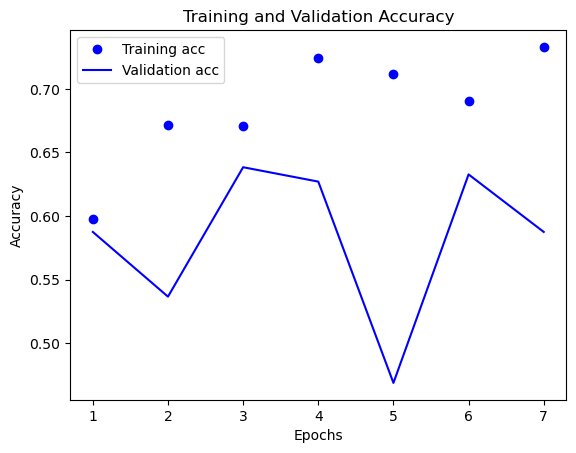

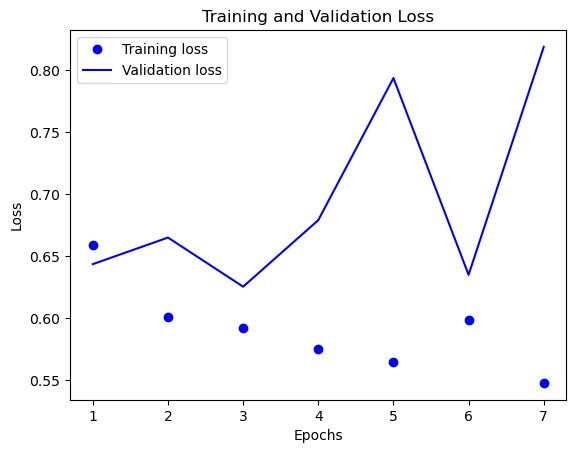

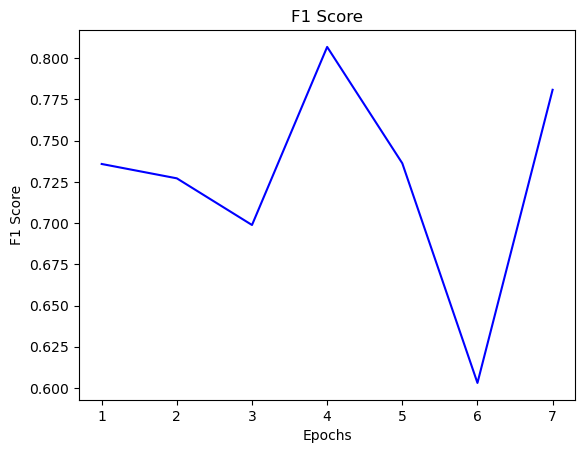

In [11]:
# define model architecture
model = models.Sequential([
    Dense(512, activation = 'relu', input_shape = (X_train.shape[1], )),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

# evaluate model
EvaluateModel(model)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 512)               19968     
                                                                 
 dense_25 (Dense)            (None, 256)               131328    
                                                                 
 dense_26 (Dense)            (None, 128)               32896     
                                                                 
 dense_27 (Dense)            (None, 64)                8256      
                                                                 
 dense_28 (Dense)            (None, 32)                2080      
                                                                 
 dense_29 (Dense)            (None, 1)                 33        
                                                                 
Total params: 194,561
Trainable params: 194,561
Non-tr

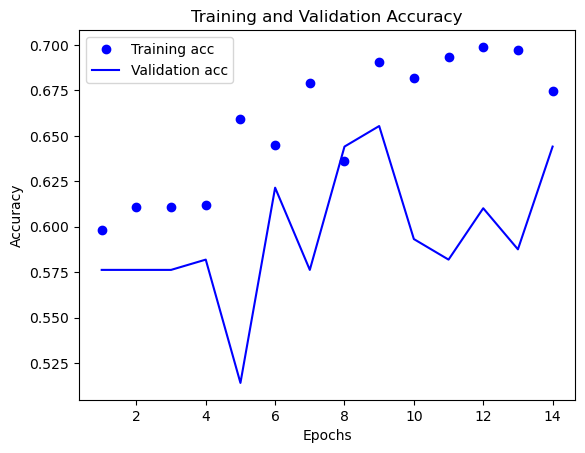

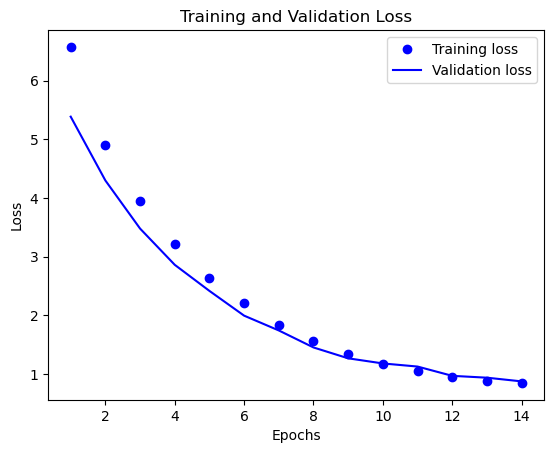

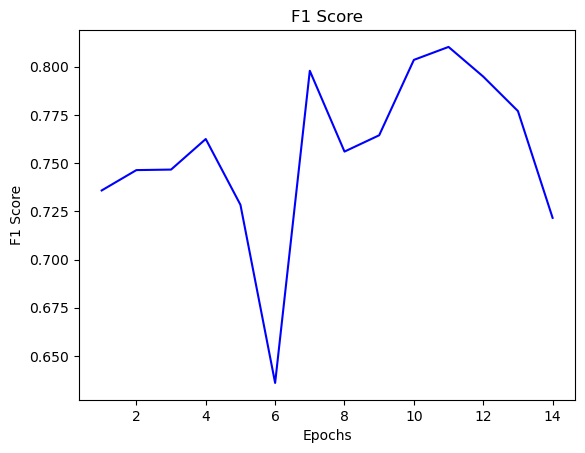

In [13]:
# penalty hyperparameter
PENALTY = 0.01

# define model architecture
model = models.Sequential([
    Dense(512, activation = 'relu', kernel_regularizer = l2(PENALTY), input_shape = (X_train.shape[1], )),
    Dense(256, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(128, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(64, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(32, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(1, activation = 'sigmoid')
])

# evaluate model
EvaluateModel(model)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 512)               19968     
                                                                 
 dense_31 (Dense)            (None, 256)               131328    
                                                                 
 dense_32 (Dense)            (None, 128)               32896     
                                                                 
 dense_33 (Dense)            (None, 64)                8256      
                                                                 
 dense_34 (Dense)            (None, 32)                2080      
                                                                 
 dense_35 (Dense)            (None, 1)                 33        
                                                                 
Total params: 194,561
Trainable params: 194,561
Non-tr

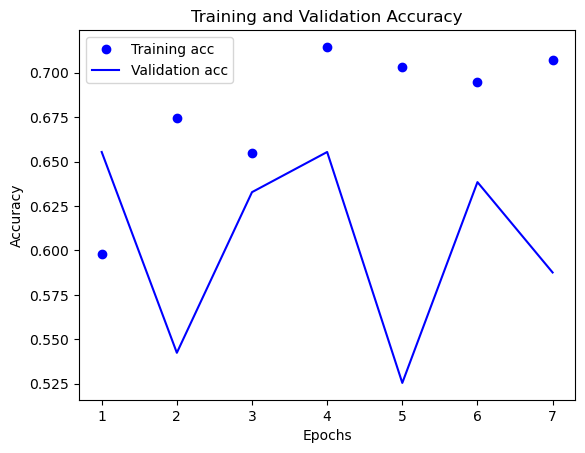

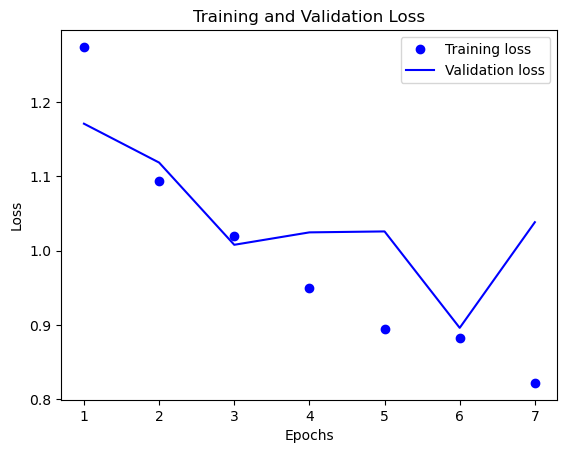

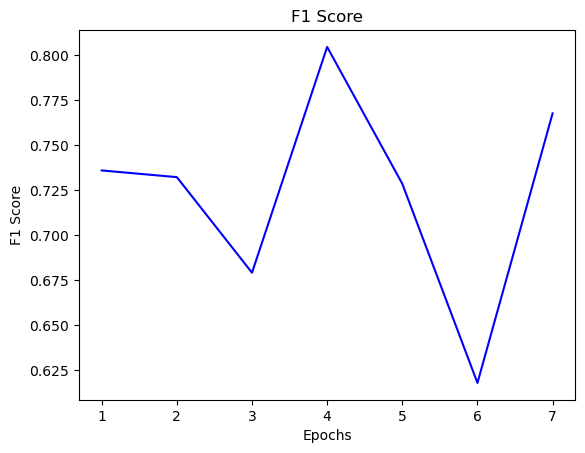

In [14]:
# penalty hyperparameter
PENALTY = 0.001

# define model architecture
model = models.Sequential([
    Dense(512, activation = 'relu', kernel_regularizer = l2(PENALTY), input_shape = (X_train.shape[1], )),
    Dense(256, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(128, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(64, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(32, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(1, activation = 'sigmoid')
])

# evaluate model
EvaluateModel(model)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 512)               19968     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_37 (Dense)            (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_38 (Dense)            (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_39 (Dense)            (None, 64)               

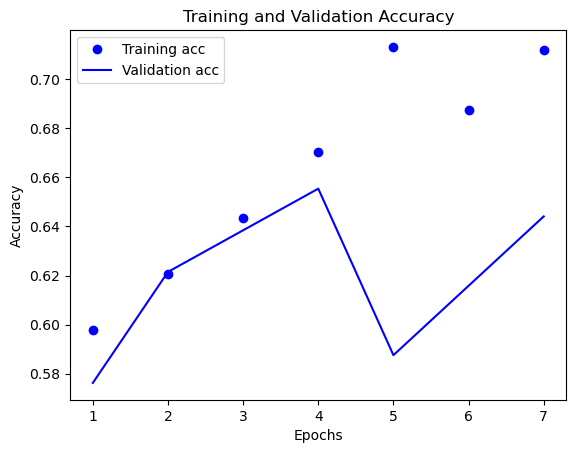

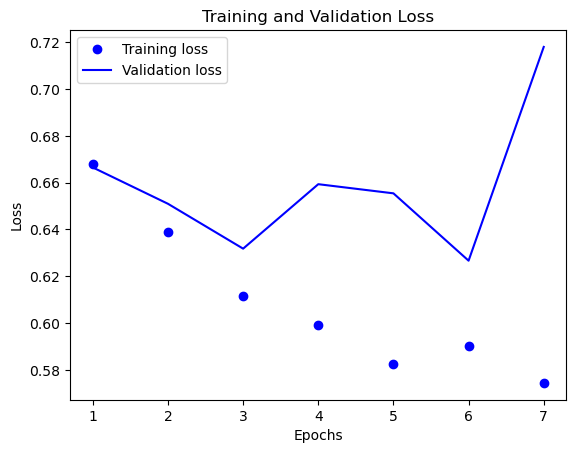

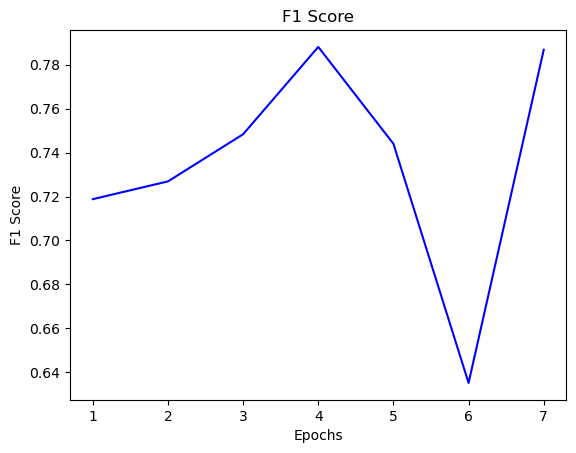

In [15]:
# penalty hyperparameter
RATE = 0.25

# define model architecture
model = models.Sequential([
    Dense(512, activation = 'relu', input_shape = (X_train.shape[1], )),
    Dropout(RATE),
    Dense(256, activation = 'relu'),
    Dropout(RATE),
    Dense(128, activation = 'relu'),
    Dropout(RATE),
    Dense(64, activation = 'relu'),
    Dropout(RATE),
    Dense(32, activation = 'relu'),
    Dropout(RATE),
    Dense(1, activation = 'sigmoid')
])

# evaluate model
EvaluateModel(model)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 512)               19968     
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_43 (Dense)            (None, 256)               131328    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_44 (Dense)            (None, 128)               32896     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_45 (Dense)            (None, 64)               

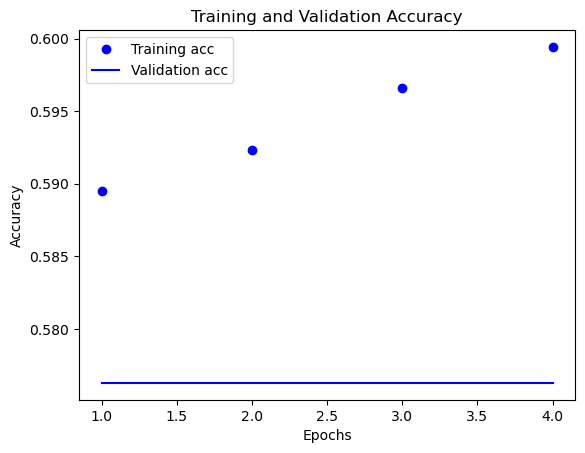

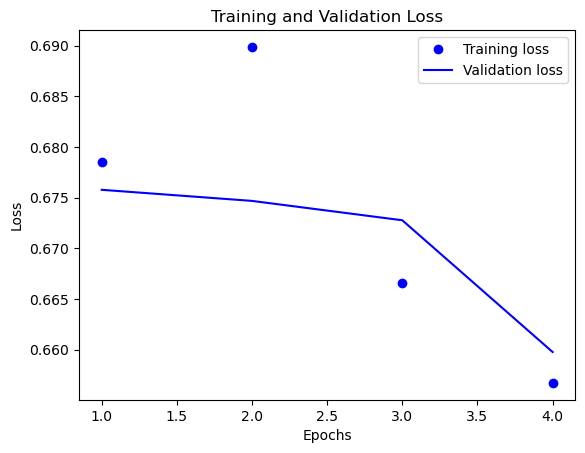

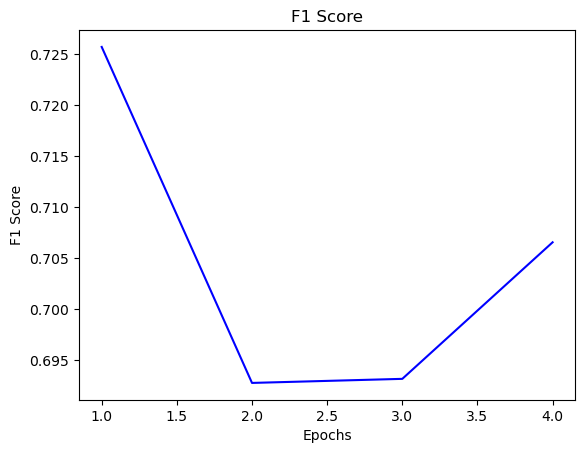

In [16]:
# penalty hyperparameter
RATE = 0.5

# define model architecture
model = models.Sequential([
    Dense(512, activation = 'relu', input_shape = (X_train.shape[1], )),
    Dropout(RATE),
    Dense(256, activation = 'relu'),
    Dropout(RATE),
    Dense(128, activation = 'relu'),
    Dropout(RATE),
    Dense(64, activation = 'relu'),
    Dropout(RATE),
    Dense(32, activation = 'relu'),
    Dropout(RATE),
    Dense(1, activation = 'sigmoid')
])

# evaluate model
EvaluateModel(model)